In [1]:
# pip install prophet --trusted-host pypi.org --trusted-host pypi.python.org

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
from neuralprophet import NeuralProphet
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('HW_6_data.csv')

In [4]:
dates = pd.to_datetime(train['dates'])
train.loc[:, ('dates')] = dates

In [5]:
test = pd.read_csv('HW_6_test.csv')

In [6]:
dates = pd.to_datetime(test['dates'])
test.loc[:, ('dates')] = dates

In [7]:
sku_list = list(set(train['SKU'].tolist()))

  0%|          | 0/10 [00:00<?, ?it/s]13:17:35 - cmdstanpy - INFO - Chain [1] start processing
13:17:35 - cmdstanpy - INFO - Chain [1] done processing


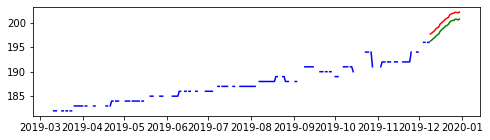

 10%|█         | 1/10 [00:01<00:17,  1.96s/it]13:17:36 - cmdstanpy - INFO - Chain [1] start processing
13:17:36 - cmdstanpy - INFO - Chain [1] done processing


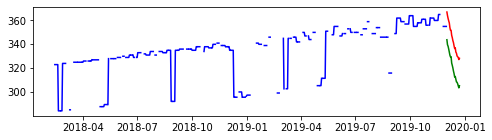

 20%|██        | 2/10 [00:02<00:09,  1.19s/it]13:17:37 - cmdstanpy - INFO - Chain [1] start processing
13:17:37 - cmdstanpy - INFO - Chain [1] done processing


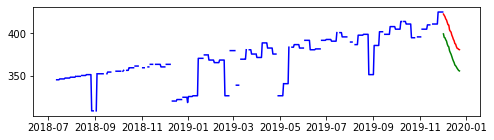

 30%|███       | 3/10 [00:03<00:06,  1.11it/s]13:17:37 - cmdstanpy - INFO - Chain [1] start processing
13:17:37 - cmdstanpy - INFO - Chain [1] done processing


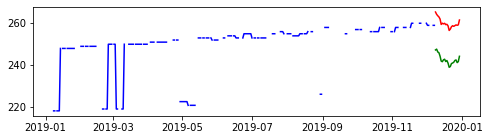

 40%|████      | 4/10 [00:03<00:04,  1.28it/s]13:17:38 - cmdstanpy - INFO - Chain [1] start processing
13:17:38 - cmdstanpy - INFO - Chain [1] done processing


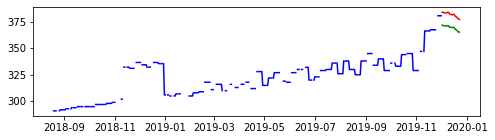

 50%|█████     | 5/10 [00:04<00:03,  1.44it/s]13:17:38 - cmdstanpy - INFO - Chain [1] start processing
13:17:38 - cmdstanpy - INFO - Chain [1] done processing


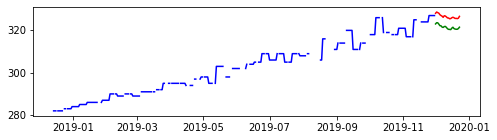

 60%|██████    | 6/10 [00:04<00:02,  1.50it/s]13:17:39 - cmdstanpy - INFO - Chain [1] start processing
13:17:39 - cmdstanpy - INFO - Chain [1] done processing


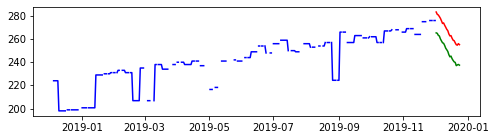

 70%|███████   | 7/10 [00:05<00:01,  1.62it/s]13:17:39 - cmdstanpy - INFO - Chain [1] start processing
13:17:40 - cmdstanpy - INFO - Chain [1] done processing


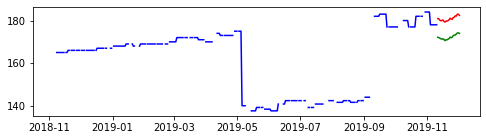

 80%|████████  | 8/10 [00:06<00:01,  1.63it/s]13:17:40 - cmdstanpy - INFO - Chain [1] start processing
13:17:40 - cmdstanpy - INFO - Chain [1] done processing


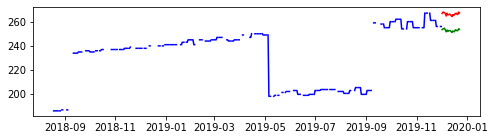

 90%|█████████ | 9/10 [00:06<00:00,  1.70it/s]13:17:41 - cmdstanpy - INFO - Chain [1] start processing
13:17:41 - cmdstanpy - INFO - Chain [1] done processing


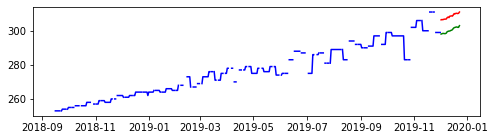

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


In [8]:
df_list = []

for sku in tqdm(sku_list):
    # fill gaps in train data
    df = train[train['SKU'] == sku].reset_index(drop=True)
    period = (df['dates'].max() - df['dates'].min()).days + 1
    
    extender = pd.DataFrame()
    extender['dates'] = [df['dates'].min() + timedelta(days=1) * n for n in range(period)]
    df_ext = extender.merge(df, how='left', on='dates')
    
    # fill gaps in test data
    df_test = test[test['SKU'] == sku].reset_index(drop=True)
    period = (df_test['dates'].max() - df['dates'].max()).days

    extender = pd.DataFrame()
    extender['dates'] = [df['dates'].max() + timedelta(days=1) * (n + 1) for n in range(period)]
    df_test_ext = extender.merge(df_test, how='left', on='dates').drop(['SKU'], axis=1)
    
    # prepare data
    df0 = pd.DataFrame()
    df0['ds'] = df_ext['dates']
    df0['y'] = df_ext['price_per_sku']

    df1 = pd.DataFrame()
    df1['ds'] = df_test_ext['dates']
    df1['y'] = None
    
    # predict
    m = Prophet(
         yearly_seasonality=True,
        uncertainty_samples=1000
    )
    metrics = m.fit(df0);
    forecast = m.predict(df1)
    
    # merge
    df2 = pd.DataFrame()
    df2['dates'] = df1['ds']
    df2['predicted_lower_bound'] = forecast['yhat_lower']
    df2['predicted_upper_bound'] = forecast['yhat_upper']

    df_list.append(df_test.merge(df2, how='left', on='dates'))
    
    # visualize
    plt.figure(figsize=(8, 2))
    plt.plot(df0['ds'], df0['y'], color='b')
    plt.plot(df1['ds'], forecast['yhat_upper'], color='r')
    plt.plot(df1['ds'], forecast['yhat_lower'], color='g')
    plt.show()

In [9]:
df = pd.concat(df_list).reset_index(drop=True)

df.to_csv('part2.csv', index=False)